<a href="https://colab.research.google.com/github/annaiandresen/whats-ur-l1/blob/master/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training using BERT

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pytorch
!pip install datasets
!pip install transformers

In [ ]:
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, \
    BertForSequenceClassification, pipeline
import datasets

In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/model/dataset_three_labels.csv", usecols=['text', 'label']) 
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)
df = df[:500000]
df

,text,label
0,Oo [the kind of time frame i'd expect for the ...,0
1,"Don't laugh, but France really might destroy w...",0
2,Use good tomatoes?,1
3,How ever I can know about there was no ban?,2
4,Assuming it will be with the indigenous people...,2
...,...,...
499995,and confirmed by yourself so why did you see i...,2
499996,Usually served over rice.,0
499997,Isn't the CB in Turkey independent of the gove...,1
499998,Pirates will save the day.,1


In [ ]:
import numpy as np
# Shuffle and split into 60 / 20 / 20
train, val, test = np.split(df.sample(frac=1), [int(.6 * len(df)), int(.8 * len(df))])
train

,text,label
188517,And then spreads into territories that were un...,2
249506,"I love learning about, and conversing with peo...",1
200618,French can't help it.,0
428459,`` rewarding incompetence ''?,0
354774,"Don't be too harsh on them, it's just them try...",2
...,...,...
466811,"Our government has no balls, sadly.",2
279229,That will give me more power than a GTX 780 Ti.,2
288383,It's a Prime player with great micro and someb...,1
119746,Idiot.,2


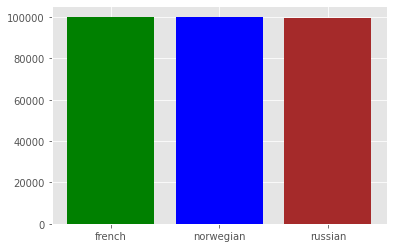

In [ ]:
import matplotlib.pyplot as plt

# Check that we have an equal number of labels for each language in our train set
dd = pd.Series(train['label'].values).value_counts()
colors = ['green', 'blue','brown']
plt.style.use('ggplot')  # Use ggplot styles
plt.bar(['french', 'norwegian', 'russian'], dd.values, color=colors)
plt.show()

In [ ]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
def tokenize_element(dataset: datasets.Dataset) -> datasets.Dataset:
    """
        Tokenizes each sentence in dataset
        :param dataset: a Dataset object.
        :return: a tokenized dataset.
    """
    dataset_tok = dataset.map(
            lambda ds: tokenizer(ds['text'], truncation=True, padding='max_length', max_length=512),
            batched=True).remove_columns(['text', '__index_level_0__'])
    dataset_tok.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
    dataset_tok.rename_column("label", "labels")
    return dataset_tok

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_ds, val_ds, test_ds = datasets.Dataset.from_pandas(train), datasets.Dataset.from_pandas(val), datasets.Dataset.from_pandas(test)

train_ds_tok = tokenize_element(train_ds)
val_ds_tok = tokenize_element(val_ds)
test_ds_tok = tokenize_element(test_ds)

ds = datasets.DatasetDict(
            {
                "train": train_ds_tok,
                "val": val_ds_tok,
                "test": test_ds_tok
            }
        )
ds.save_to_disk("/content/gdrive/MyDrive/model/bert/hf_medium")

  0%|          | 0/300 [00:00<?, ?ba/s]

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/100 [00:00<?, ?ba/s]

In [ ]:
ds = datasets.DatasetDict.load_from_disk("/content/gdrive/MyDrive/model/bert/hf_medium")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300000
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100000
    })
})

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3).to(device)
model

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    #r = recall_score(labels, preds)
    #p = precision_score(labels, preds)
    return {
        'accuracy': acc,
    }

In [ ]:
train_args = TrainingArguments(
            output_dir="/content/gdrive/MyDrive/model/bert/better_rate",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=1,
            weight_decay=0.01,
        )
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
            model=model,  # the instantiated Transformers model to be trained
            args=train_args,  # training arguments, defined above
            train_dataset=ds['train'],  # training dataset
            eval_dataset=ds['val'],  # evaluation dataset
            compute_metrics=compute_metrics,  # the callback that computes metrics of interest
            data_collator=data_collator)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 300000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 18750


Step,Training Loss
500,0.529400
1000,0.906000
1500,0.876900
2000,0.860500
2500,0.843900
3000,0.845500
3500,0.843300
4000,0.831800
4500,0.827400
5000,0.816800


Saving model checkpoint to /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-500
Configuration saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-500/config.json
Model weights saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-1000
Configuration saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-1000/config.json
Model weights saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-1500
Configuration saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-1500/config.json
Model weights saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-2000
Configuration saved in /content/gdriv

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/model/bert/better_rate/checkpoint-17500"
trainer.train(resume_from_checkpoint=checkpoint_path)

Loading model from /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-17500).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 300000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 18750
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 17500
  Will skip the first 0 epochs then the first 17500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the trai

  0%|          | 0/17500 [00:00<?, ?it/s]

Step,Training Loss
18000,0.772000
18500,0.766600


Saving model checkpoint to /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-18000
Configuration saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-18000/config.json
Model weights saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-18000/pytorch_model.bin
Saving model checkpoint to /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-18500
Configuration saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-18500/config.json
Model weights saved in /content/gdrive/MyDrive/model/bert/better_rate/checkpoint-18500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=18750, training_loss=0.05137145263671875, metrics={'train_runtime': 1257.7202, 'train_samples_per_second': 238.527, 'train_steps_per_second': 14.908, 'total_flos': 7.89340253184e+16, 'train_loss': 0.05137145263671875, 'epoch': 1.0})

In [ ]:
trainer.save_model("/content/gdrive/MyDrive/model/bert/better_rate")

Saving model checkpoint to /content/gdrive/MyDrive/model/bert/better_rate
Configuration saved in /content/gdrive/MyDrive/model/bert/better_rate/config.json
Model weights saved in /content/gdrive/MyDrive/model/bert/better_rate/pytorch_model.bin


In [ ]:
pred = trainer.predict(ds['test'])

***** Running Prediction *****
  Num examples = 100000
  Batch size = 16


In [ ]:
pred

PredictionOutput(predictions=array([[-0.7928781 , -1.6575369 ,  2.2908645 ],
       [ 0.7489031 , -0.45401093, -0.26130697],
       [-1.2502555 ,  0.6456994 ,  0.63118327],
       ...,
       [ 1.0847744 ,  0.01399221, -1.1939424 ],
       [ 0.44552004, -0.49618796, -0.02806599],
       [ 0.11919194, -0.46705887,  0.30527493]], dtype=float32), label_ids=array([1, 0, 2, ..., 0, 0, 0]), metrics={'test_loss': 0.7538742423057556, 'test_accuracy': 0.64829, 'test_runtime': 1753.0443, 'test_samples_per_second': 57.044, 'test_steps_per_second': 3.565})

In [ ]:
eval = trainer.evaluate()
eval

***** Running Evaluation *****
  Num examples = 100000
  Batch size = 16


{'epoch': 1.0,
 'eval_accuracy': 0.64745,
 'eval_loss': 0.7540492415428162,
 'eval_runtime': 1756.9003,
 'eval_samples_per_second': 56.918,
 'eval_steps_per_second': 3.557}

In [ ]:
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)
def predict_sentence(sentence: str):
        res = pipe(sentence)
        label = res[0]['label']
        print("Predicting L1 of the author of the sentence: ", sentence)
        print(label_to_language(label))
        print("Score: ", res[0]['score'])
        return res
        
def label_to_language(label: str) -> str:
    if label == "LABEL_0":
        return "French"
    elif label == "LABEL_1":
        return "Norwegian"
    elif label == "LABEL_2":
        return "Russian"
    return label

In [ ]:
nor_sent = "Hi my name is Anna and I'm from Norway"
predict_sentence(nor_sent)
french_sent = "I'm visiting my family in Québec"
predict_sentence(french_sent)
russ_sent = "I was born in Moscow"
predict_sentence(russ_sent)

Predicting L1 of the author of the sentence:  Hi my name is Anna and I'm from Norway
Norwegian
Score:  0.9663804173469543
Predicting L1 of the author of the sentence:  I'm visiting my family in Québec
French
Score:  0.9770438075065613
Predicting L1 of the author of the sentence:  I was born in Moscow
Russian
Score:  0.9794569611549377


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


[{'label': 'LABEL_2', 'score': 0.9794569611549377}]

In [ ]:
y_test = ds['test']['label']

In [ ]:
y_pred = pred.predictions

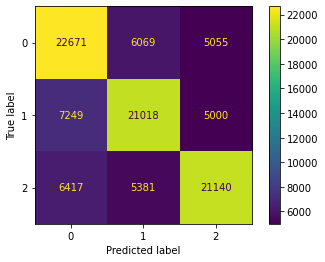

In [ ]:
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=y_test, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1", "2"])
disp.plot()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
report = classification_report(y_pred=np.argmax(y_pred, axis=1), y_true=y_test, target_names=["0", "1", "2"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.623910,0.670839,0.646524,33795.00000
1,0.647345,0.631797,0.639477,33267.00000
2,0.677673,0.641812,0.659255,32938.00000
accuracy,0.648290,0.648290,0.648290,0.64829
macro avg,0.649642,0.648149,0.648418,100000.00000
weighted avg,0.649414,0.648290,0.648373,100000.00000
